# Expected goals model

En este tema vamos a aprender a realizar un modelo básico para el estudio del fútbol, el **expected goals model**, que podríamos traducir algo así como el modelo de goles esperados. 

Este va a ser nuestro primer modelo estadístico con el que vamos a tratar de predecir unos resultados, goles, a partir de datos de diferentes eventos, disparos a puerta, utilizando nuestras herramientas de python



## ¿Qué es un expected goals?

Podráimos definirlo como *la probabilidad de que en un día típico de fútbol un particular disparo a puerta desde una determinada posición acabe siendo gol*, es decir nos da la probabilidad que tiene un disparo a puerta de ser gol.

Esta información la obtenemos analizando una enorme cantidad de partidos con los que *hemos entrenado* a nuestro modelo

## ¿ Por qué son importantes los expected goals?

Hay bastantes razones pero os voy a dar unas pocas:

1. La primera razón es porque nos cuentan una historia sobre un partido que no podemos obtener únicamente del resultado final.

2. La segunda razón es porque pueden usarse como guía para ayudar a jugadores y entrenadores a la hora de tomar decisiones de cara al gol.

![Atleti.jpg](Atleti.jpg)



## Cargando los datos

Vamos a comenzar importando las librerías que vamos a necesitar. En este problema vamos a trabajar con los datos de yscout para jugar con otros datos. (Wyscout data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2) Vamos a cargar los datos de la liga inglesa

In [1]:
#Las librerías básicas
import json
import numpy as np
import pandas as pd

In [2]:
# Cargamos los datos de la liga inglesa en nuestra variable data

with open('Wyscout/events/events_Spain.json') as f:
    data = json.load(f)
  

In [3]:
#Creamos un DataFrame de pandas

train = pd.DataFrame(data)
train.head()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422


In [4]:
# Vemos que la columna que nos interesa es la de subEventName, que dice que tipo de evento futbolístico tenemos.
# Veamos que tipo de eventos hay usando la función unique()

pd.unique(train['subEventName'])


array(['Simple pass', 'Smart pass', 'Cross', 'Ground defending duel',
       'Acceleration', 'Ground attacking duel', 'Shot', 'Reflexes',
       'Touch', 'Ball out of the field', 'Corner', 'Goal kick',
       'Throw in', 'High pass', 'Head pass', 'Launch',
       'Ground loose ball duel', 'Foul', 'Free Kick', 'Clearance',
       'Air duel', '', 'Free kick cross', 'Hand foul', 'Save attempt',
       'Hand pass', 'Goalkeeper leaving line', 'Penalty',
       'Free kick shot', 'Late card foul', 'Time lost foul', 'Whistle',
       'Simulation', 'Protest', 'Out of game foul', 'Violent Foul'],
      dtype=object)

In [5]:
# Extraemos entonces los eventos que nos interesan que son los disparos a puerta
shots=train[train['subEventName']=='Shot']

shots.head()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
20,10,Shot,"[{'id': 1901}, {'id': 401}, {'id': 201}, {'id'...",225089,"[{'y': 34, 'x': 93}, {'y': 0, 'x': 0}]",2565548,Shot,695,1H,57.771186,100,180865315
22,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",255738,"[{'y': 59, 'x': 80}, {'y': 0, 'x': 0}]",2565548,Shot,695,1H,60.727239,100,180864547
107,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 201}, {'id'...",37831,"[{'y': 57, 'x': 88}, {'y': 100, 'x': 100}]",2565548,Shot,682,1H,446.986112,100,180864486
111,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",15214,"[{'y': 66, 'x': 87}, {'y': 100, 'x': 100}]",2565548,Shot,682,1H,488.929113,100,180864491
228,10,Shot,"[{'id': 402}, {'id': 1214}, {'id': 1802}]",225089,"[{'y': 40, 'x': 75}, {'y': 0, 'x': 0}]",2565548,Shot,695,1H,948.872079,100,180864792


In [6]:
#Go through the dataframe and calculate X, Y co-ordinates.
#Distance from a line in the centre
#Shot angle.
#Details of tags can be found here: https://apidocs.wyscout.com/matches-wyid-events

shots_model=pd.DataFrame(columns=['Goal','X','Y'])
for i,shot in shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1



In [7]:
shots_model

,Goal,X,Y,C,Distance,Angle
20,0,7,34,16.0,12.735089,0.346975
22,0,20,59,9.0,21.799599,0.321317
107,0,12,57,7.0,13.396361,0.506972
111,0,13,66,16.0,17.160492,0.341540
228,0,25,40,10.0,27.042790,0.261520
...,...,...,...,...,...,...
628323,0,7,66,16.0,12.735089,0.346975
628374,0,10,32,18.0,15.720687,0.317684
628540,1,8,25,25.0,18.292690,0.189128
628596,0,18,30,20.0,22.939268,0.263508


In [8]:
#Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
  

In [9]:
#Two dimensional histogram
H_Shot=np.histogram2d(shots_model['X'], shots_model['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_model[shots_model['Goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])

In [10]:
def createGoalMouth():
    #Adopted from FC Python
    #Create figure
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax



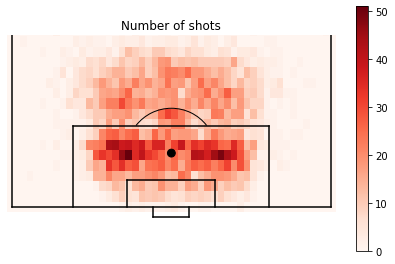

In [11]:
#Plot the number of shots from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('NumberOfShots.pdf', dpi=None, bbox_inches="tight")   



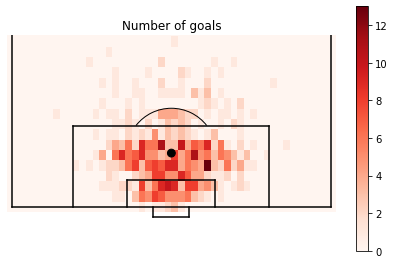

In [12]:
#Plot the number of GOALS from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('NumberOfGoals.pdf', dpi=None, bbox_inches="tight")   




/var/folders/bp/v78k11s50pdbmf3gy9nync040000gn/T/ipykernel_6596/3280902137.py:3: RuntimeWarning: invalid value encountered in true_divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


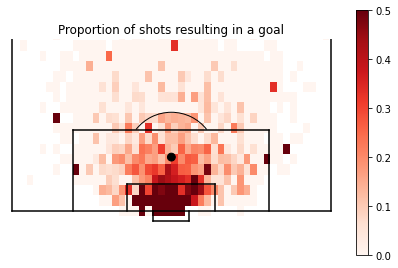

In [13]:
#Plot the probability of scoring from different points
(fig,ax) = createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   



## Ajustando un modelo

Hasta ahora lo que hemos hecho ha sido elegir unas variables y ver sus histogramas para ver que idea nos daban, pero no hemos ajustado ningún modelo matemático. Ajustar un modelo a nuestros datos es lo que nos va a permitir predecir.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Ejemplo de un ajuste lineal

Vamos a ver un ejemplo de un ajuste lineal, que nos puede resultar más fácil de entender. Vamos ajustar los siguientes datos: 
1. Número de minutos jugados
2. Número de goles

In [15]:
#Escribimos unos datos sobre minutos jugados y goles metidos
minutes_played=np.array([120,452,185,708,340,561])
goals_scored=np.array([1,6,3,7,3,5])

#Y lo transformamos en un DataFrame
minutes_model = pd.DataFrame()
minutes_model = minutes_model.assign(minutes=minutes_played)
minutes_model = minutes_model.assign(goals=goals_scored)



In [16]:
minutes_model


,minutes,goals
0,120,1
1,452,6
2,185,3
3,708,7
4,340,3
5,561,5


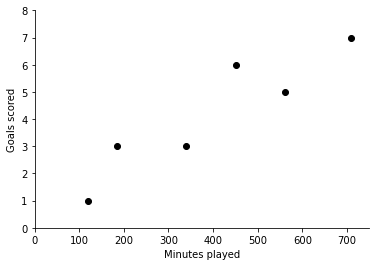

In [17]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goals scored')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8));



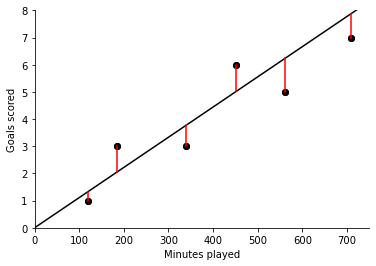

In [18]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goals scored')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))


#Slope of one goal per 90 played
b=1/90
#Intercept
a=0

x=np.arange(800,step=0.1)
y= a + b*x 

ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[goals_scored[i],a+b*mp], color='red')


plt.show()




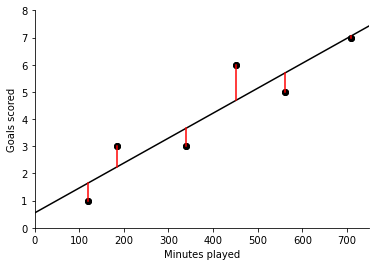

In [19]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goals scored')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))


#Slope determined by linear regression
model_fit=smf.ols(formula='goals_scored ~ minutes_played ', data=minutes_model).fit()
#print(model_fit.summary())        
[a,b]=model_fit.params

x=np.arange(800,step=0.1)
y= a + b*x 

ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[goals_scored[i],a+b*mp], color='red')


plt.show()


/Users/galeanojav/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                                 OLS Regression Results                                
Dep. Variable:           goals_scored   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              156.1
Date:                Mon, 07 Feb 2022   Prob (F-statistic):                    5.83e-05
Time:                        12:44:32   Log-Likelihood:                         -7.2998
No. Observations:                   6   AIC:                                      16.60
Df Residuals:                       5   BIC:                                      16.39
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

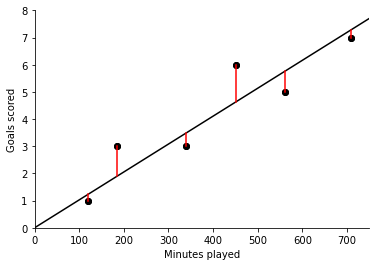

In [20]:
fig,ax=plt.subplots(num=1)
ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Goals scored')
ax.set_xlabel('Minutes played')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((0,750))
plt.ylim((0,8))


#Slope determined by linear regression
model_fit=smf.ols(formula='goals_scored ~ minutes_played -1', data=minutes_model).fit()
print(model_fit.summary())        
[b]=model_fit.params

a=0
x=np.arange(800,step=0.1)
y= a + b*x 

ax.plot(minutes_played, goals_scored, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(x, y, color='black')

#Show distances to line
for i,mp in enumerate(minutes_played):
    ax.plot([mp,mp],[goals_scored[i],a+b*mp], color='red')


plt.show()



In [21]:
1/b

97.3466469428008

### Logistic curve

Pero en nuestro caso parece que un ajuste lineal no va a ir bien. Primero porque queremos ajustar probabilidades que van a ir de 0 a 1, y va a llegar un momento que se tienen que suavizar al llegar a los límites. 

Para eso en los años 50 se inventó la ecuación logística, que tiene la forma:

$$
y=\frac{1}{1+ e^{b_0 + b_1 x}}
$$

démonos cuenta que en realidad la idea es la misma tenemos que encontrar los parámetros $b_0$ y $b_1$ que mejor se ajusten a nustros datos.

En realidad esto es uno de los problemas clásicos en Machine Learning que es el problema de regresión. 

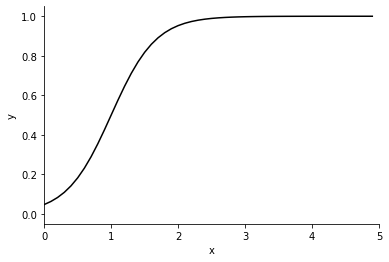

In [22]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(+b[0]+b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



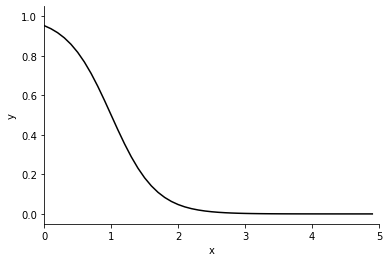

In [23]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)
y=1/(1+np.exp(-b[0]-b[1]*x))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



/var/folders/bp/v78k11s50pdbmf3gy9nync040000gn/T/ipykernel_6596/1294969170.py:4: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


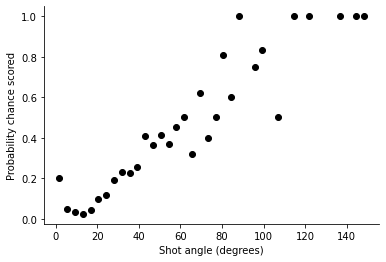

In [24]:
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6606
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1908.7
Date:                    Mon, 07 Feb 2022   Deviance:                       3817.4
Time:                            12:44:53   Pearson chi2:                 6.12e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.09699
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

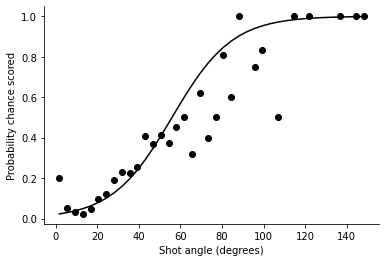

In [25]:
test_model = smf.glm(formula="Goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
fig.savefig('ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")   





/var/folders/bp/v78k11s50pdbmf3gy9nync040000gn/T/ipykernel_6596/83466701.py:3: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


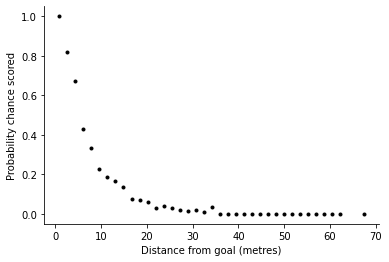

In [26]:
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



In [27]:
#Make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
fig.savefig('ProbabilityOfScoringDistance.pdf', dpi=None, bbox_inches="tight")   




                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6606
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1891.9
Date:                    Mon, 07 Feb 2022   Deviance:                       3783.8
Time:                            12:45:08   Pearson chi2:                 3.10e+07
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1016
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6606
Model Family:                    Binomial   Df Model:                            1
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1891.9
Date:                    Mon, 07 Feb 2022   Deviance:                       3783.8
Time:                            12:45:12   Pearson chi2:                 3.10e+07
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1016
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

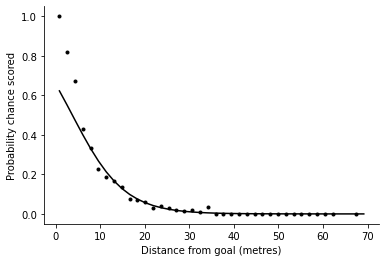

In [28]:
#Adding distance squared
#squaredD = shots_model['Distance']**2
#shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="Goal ~ Distance " , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance) )
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
fig.savefig('ProbabilityOfScoringDistanceSquared.pdf', dpi=None, bbox_inches="tight")   




In [29]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

model

'Angle + Distance'

In [30]:
#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 6608
Model:                                GLM   Df Residuals:                     6605
Model Family:                    Binomial   Df Model:                            2
Link Function:                      logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -1859.4
Date:                    Mon, 07 Feb 2022   Deviance:                       3718.8
Time:                            12:45:19   Pearson chi2:                 1.52e+05
No. Iterations:                         7   Pseudo R-squ. (CS):             0.1104
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [31]:
#Return xG value for more general model
def calculate_xG(sh):    
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum)) 
    return xG   

#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)


In [32]:
shots_model.head()

,Goal,X,Y,C,Distance,Angle,xG
20,0,7,34,16.0,12.735089,0.346975,0.125891
22,0,20,59,9.0,21.799599,0.321317,0.051017
107,0,12,57,7.0,13.396361,0.506972,0.153539
111,0,13,66,16.0,17.160492,0.341540,0.082743
228,0,25,40,10.0,27.042790,0.261520,0.027191


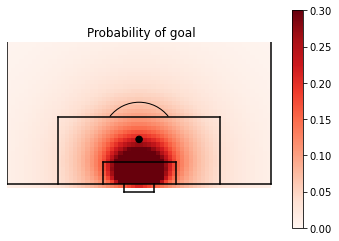

In [33]:
#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   

